# Here we'll train some models!

In [4]:
from __future__ import annotations

# Standard library
import sys
import pathlib
import warnings

# Third-party
import numpy as np
import pandas as pd
import yaml
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNetCV, LassoCV, LinearRegression, RidgeCV, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    KFold,
    RepeatedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# --- project paths
PROJ = pathlib.Path().resolve().parent
CFG  = yaml.safe_load(open(PROJ / "conf" / "config.yaml"))
var_types = yaml.safe_load(open(PROJ / "conf" / "variable_types.yaml"))
RAW_DIR = PROJ / CFG["data"]["raw_dir"]
PROC_DIR = PROJ / CFG["data"]["processed_dir"]
numeric_cols = var_types["numeric_variables"]
RULES = yaml.safe_load(open(PROJ/"conf"/"cleaning_rules.yaml"))

if str(PROJ) not in sys.path:
    sys.path.insert(0, str(PROJ))

from pipeline.transformers import (AutoTransform) 

PerfWarn = pd.errors.PerformanceWarning
warnings.filterwarnings("ignore", category=PerfWarn)

# ---------- Column groups from config ----------
TYPES = yaml.safe_load(open(PROJ/"conf"/"variable_types.yaml"))

In [5]:
# First read in the file...
df = pd.read_parquet(PROC_DIR / "cbecs_2018_clean.parquet")
cat_cols = [c for c in TYPES["categorical_variables"] if c in df.columns]
num_cols = [c for c in TYPES["numeric_variables"] if c in df.columns]

# Coerce all non-numeric columns to be astype object. Many are actually integers that refer to codes.
df[cat_cols] = df[cat_cols].astype(object)


# Assign X, y 
X = df.drop('LOG_MFBTU', axis=1)
y = df['LOG_MFBTU']

# Split the data into validation, train, and test sets
# e.g., 80/10/10 split
test_size = 0.10
val_size  = 0.10
rand      = 1

# 1) Hold out test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=rand, shuffle=True
)

# 2) From the remainder, carve out validation
val_rel = val_size / (1.0 - test_size)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=val_rel, random_state=rand, shuffle=True
    )

# Check and make sure the splits worked as expected...
df.shape
check_shape = X_train.shape[0]+X_test.shape[0]+X_val.shape[0] == df.shape[0]

print(f"Split correctly: {check_shape}")

Split correctly: True


### Let's first train up a very simple baseline to test our models against. We'll try two options: 

1. Predict the mean of the target.
2. Use only `SQFT` as a model feature, as this is a highly predictive feature.

In [6]:
from __future__ import annotations
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

def baseline_with_sqft(
    X_train,
    y_train,
    X_test=None,
    y_test=None,
    feature="num__SQFT_log1p",
    print_lines=True,
    decimals=4,
):
    """
    Two baselines:
      1) Predict the mean of y_train.
      2) LinearRegression with a single feature (default: 'num__SQFT_log1p').

    Prints one summary line per test if print_lines=True, and returns a dict.
    """

    # -- Prepare targets --
    y_train = np.asarray(y_train).ravel()
    y_eval = y_train if y_test is None else np.asarray(y_test).ravel()
    n = int(y_eval.shape[0])

    # ---------- Baseline 1: mean predictor ----------
    yhat_mean_value = float(np.mean(y_train))
    yhat_mean = np.full_like(y_eval, fill_value=yhat_mean_value, dtype=float)
    r2_mean = r2_score(y_eval, yhat_mean)
    resid_mean = y_eval - yhat_mean
    sse_mean = float(np.sum(resid_mean**2))
    mse_mean = float(sse_mean / n)

    mean_results = {
        "yhat_mean": yhat_mean_value,
        "r2": r2_mean,
        "sse": sse_mean,
        "mse": mse_mean,
        "n": n,
    }

    # --- Helper to slice the feature column as 2D ---
    def _col2d(X, feat):
        if isinstance(X, pd.DataFrame):
            if feat not in X.columns:
                raise KeyError(f"Column '{feat}' not found in X.")
            return X[[feat]].to_numpy()
        X = np.asarray(X)
        if isinstance(feat, (int, np.integer)):
            return X[:, [feat]]
        raise TypeError("For ndarray X, 'feature' must be an int index; "
                        "for DataFrame X, it must be a column name.")

    # ---------- Baseline 2: one-feature LinearRegression ----------
    Xtr_col = _col2d(X_train, feature)
    lr = LinearRegression().fit(Xtr_col, y_train)

    Xev_col = Xtr_col if X_test is None else _col2d(X_test, feature)
    yhat_lr = lr.predict(Xev_col)
    r2_lr = r2_score(y_eval, yhat_lr)
    resid_lr = y_eval - yhat_lr
    sse_lr = float(np.sum(resid_lr**2))
    mse_lr = float(sse_lr / n)

    lr_results = {
        "r2": r2_lr,
        "sse": sse_lr,
        "mse": mse_lr,
        "coef": float(lr.coef_[0]),
        "intercept": float(lr.intercept_),
        "n": n,
    }

    results = {"mean": mean_results, "lr_one_feature": lr_results}

    if print_lines:
        d = decimals
        print(f"BASELINE mean: R2={r2_mean:.{d}f}  SSE={sse_mean:.{d}f}  MSE={mse_mean:.{d}f}  n={n}")
        print(f"LR[{feature}]: coef={lr.coef_[0]:.{d}f}  intercept={lr.intercept_:.{d}f}  "
              f"R2={r2_lr:.{d}f}  SSE={sse_lr:.{d}f}  MSE={mse_lr:.{d}f}  n={n}")

    return results

# --- Example usage ---
results = baseline_with_sqft(X_train, y_train, X_test, y_test, feature="SQFT_log1p")

BASELINE mean: R2=-0.0075  SSE=2726.6586  MSE=4.2872  n=636
LR[SQFT_log1p]: coef=1.0556  intercept=3.4813  R2=0.8234  SSE=478.0188  MSE=0.7516  n=636


# Run Linear-specific pipeline to finish preparing the data

In [ ]:
# import numpy as np
# from sklearn.compose import ColumnTransformer, make_column_selector as selector
# from sklearn.preprocessing import OneHotEncoder, StandardScaler
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import cross_val_score, KFold
# from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
# from sklearn.base import clone
# from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler, FunctionTransformer
# Numeric pipeline:
# 1) MedianImputer: fill numeric NaNs using  RULES (custom transformer).
# 2) AutoTransform: numeric-only feature engineering/selection step.
# 3) StandardScaler: scale ONLY numeric features to zero mean / unit variance.
num_pipe = Pipeline([
    ("median_imputer",SimpleImputer(strategy='median', add_indicator=True)),
    ("scaler", StandardScaler())
])

# Categorical pipeline:
# OneHotEncoder:
#   - converts categories to 0/1 columns,
#   - handle_unknown="ignore" avoids errors on unseen categories at inference,
#   - sparse_output=False returns a dense array (handy if your model expects dense).
cat_pipe = Pipeline([
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

# ColumnTransformer routes columns by dtype:
#   - 'num' receives only numeric columns (np.number) and applies num_pipe.
#   - 'cat' receives object/category/bool columns and applies cat_pipe.
#   - remainder="drop" discards any columns not caught by the selectors
preproc = ColumnTransformer(
    transformers=[
        ("num", num_pipe, selector(dtype_include=np.number)),
        ("cat", cat_pipe, selector(dtype_include=["object", "category", "bool"])),
    ],
    remainder="drop"
)

cv = KFold(n_splits=5, shuffle=True, random_state=1)

models = {
    "OLS": LinearRegression(),
    "Ridge": RidgeCV(alphas=np.logspace(-6, 6, 25), cv=5),
    "Lasso": LassoCV(cv=5, n_jobs=-1, max_iter=100_000, tol=1e-4),
    "ElasticNet": ElasticNetCV(cv=5, n_jobs=-1, l1_ratio=[0.2,0.5,0.8],
                               max_iter=100_000, tol=1e-4, selection="cyclic", random_state=42),
}

for name, m in models.items():
    # IMPORTANT: fresh (unfitted) preproc inside the pipeline for each CV split
    pipe = Pipeline([("preproc", clone(preproc)), ("model", m)])
    score = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="r2", n_jobs=-1).mean()
    print(f"{name}: {score:.3f}")

OLS: -3945450877065132544.000


KeyboardInterrupt: 

In [ ]:
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)



lasso = Pipeline([
    ("preproc", clone(preproc)),
    ("model", LassoCV(cv=5, n_jobs=-1, max_iter=100_000, tol=1e-4))
])

enet = Pipeline([
    ("preproc", clone(preproc)),
    ("model", ElasticNetCV(cv=5, n_jobs=-1,
                           l1_ratio=[0.0001, 0.2, 0.3, 0.4,0.5,0.6,0.7,0.8, 0.9999],
                           max_iter=100_000, tol=1e-4, selection="cyclic",
                           random_state=1))
])

s_lasso = cross_val_score(lasso, X_train, y_train, cv=rkf, scoring="r2", n_jobs=-1)
s_enet  = cross_val_score(enet,  X_train, y_train, cv=rkf, scoring="r2", n_jobs=-1)

print(f"Lasso  mean={s_lasso.mean():.3f} ± {s_lasso.std():.3f}")
print(f"ENet   mean={s_enet.mean():.3f}  ± {s_enet.std():.3f}")
print(f"Δ(EN-Lasso) = {(s_enet - s_lasso).mean():.4f}")

Lasso  mean=0.607 ± 0.025
ENet   mean=0.607  ± 0.025
Δ(EN-Lasso) = -0.0000


I'll pick Lasso as it's a simpler model and has fewer hyperparameters to tune. It also seems like there's essentially no performance benefit to choosing ENet. Now I'll do a finer tuning pass on the Lasso. 

In [ ]:
inner = RepeatedKFold(n_splits=5, n_repeats=5, random_state=1)
lasso = Pipeline([
    ("preproc", clone(preproc)),
    ("model", LassoCV(cv=inner, n_jobs=-1, max_iter=200_000, tol=1e-4, selection="cyclic")) #Increase number of iterations allowed for finer resolution screening if necessary
])

out = cross_validate(lasso, X_train, y_train, cv=rkf,
                     scoring="r2", n_jobs=-1, return_estimator=True)

alphas = [est.named_steps["model"].alpha_ for est in out["estimator"]]
alpha_star = float(np.median(alphas))

Now I'll use the best-selected alpha to tune up a final model.

In [ ]:
final_lasso = Pipeline([
    ("preproc", clone(preproc)),
    ("model", Lasso(alpha=alpha_star, max_iter=200_000, tol=1e-4, selection="cyclic"))
]).fit(X_train, y_train)

# Predictions
y_pred = final_lasso.predict(X_test)

# Metrics
r2_test = r2_score(y_test, y_pred)
residuals = y_test - y_pred
sse = np.sum(residuals ** 2)              # sum of squared errors
mse = sse / len(y_test)                   # mean squared error

print(f"R²  = {r2_test:.4f}")
print(f"SSE = {sse:.4f}")
print(f"MSE = {mse:.4f}")

R²  = 0.6199
SSE = 183.5862
MSE = 0.2887


In [ ]:
import numpy as np
import pandas as pd

# grab steps
pre = final_lasso.named_steps["preproc"]
mod = final_lasso.named_steps["model"]

# 1) feature names after preprocessing
# Works for sklearn >= 1.0; otherwise see fallback below.
try:
    feature_names = pre.get_feature_names_out()
except AttributeError:
    # ---- Fallback for older sklearn: build names manually ----
    feature_names = []
    for name, trans, cols in pre.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if trans == "passthrough":
            # cols may be a list/array of column names or indices
            if isinstance(cols, slice):
                raise ValueError("Slice columns not supported in this fallback.")
            feature_names.extend([str(c) for c in cols])
        else:
            # try to get names from the transformer itself (e.g., OneHotEncoder)
            if hasattr(trans, "get_feature_names_out"):
                # if cols are indices, convert to strings
                base = np.array(cols).astype(str)
                feature_names.extend(trans.get_feature_names_out(base))
            else:
                # last resort: use the transformer name as a prefix
                if isinstance(cols, (list, np.ndarray)):
                    feature_names.extend([f"{name}__{c}" for c in cols])
                else:
                    feature_names.append(f"{name}")

feature_names = np.asarray(feature_names)

# 2) coefficients (already aligned with transformed columns)
coefs = mod.coef_.ravel()

# 3) tidy DataFrame
coef_df = pd.DataFrame(
    {
        "feature": feature_names,
        "coef": coefs,
        "abs_coef": np.abs(coefs),
        "nonzero": coefs != 0.0,
    }
).sort_values("abs_coef", ascending=False).reset_index(drop=True)


coef_df.head(10)

,feature,coef,abs_coef,nonzero
0,cat__PBA_6,0.446904,0.446904,True
1,cat__BOOSTWT_nan,-0.443385,0.443385,True
2,cat__PBA_4,0.422871,0.422871,True
3,cat__ENRGYPLN_nan,-0.394876,0.394876,True
4,cat__PRHT1_1,-0.355829,0.355829,True
5,cat__PBA_5,-0.319885,0.319885,True
6,num__SQFT_sqrt,-0.311862,0.311862,True
7,cat__DRVTHRU_0.0,-0.263987,0.263987,True
8,cat__SERVERC_4.0,0.201178,0.201178,True
9,cat__WHRECOV_nan,-0.199760,0.199760,True


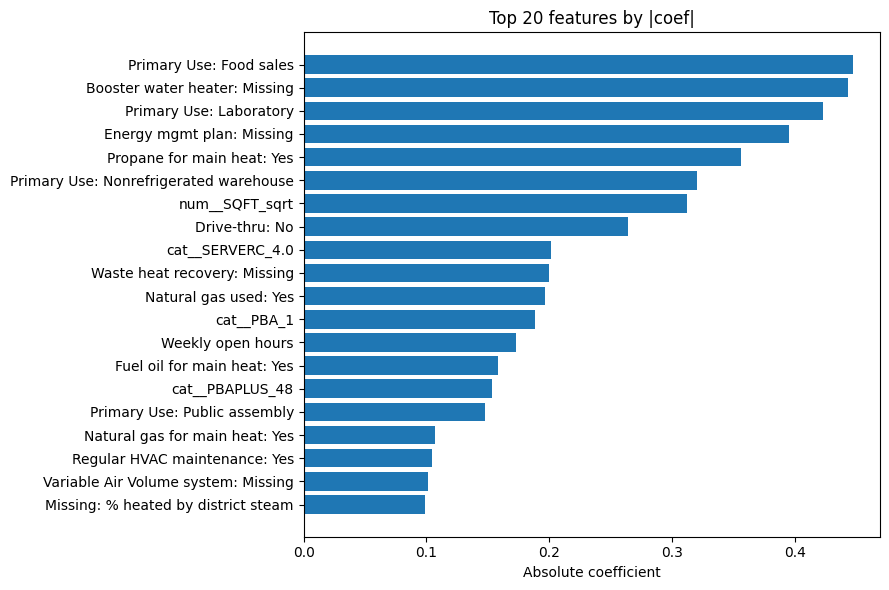

In [ ]:
# Mapping from feature strings (your first 20) to readable labels
readable_map = {
    "num__SQFT_log1p": "Square footage",
    "cat__PBA_4": "Primary Use: Laboratory",
    "cat__PRHT1_1": "Propane for main heat: Yes",
    "cat__PBA_6": "Primary Use: Food sales",
    "cat__PBA_5": "Primary Use: Nonrefrigerated warehouse",
    "cat__BOOSTWT_nan": "Booster water heater: Missing",
    "cat__ENRGYPLN_nan": "Energy mgmt plan: Missing",
    "cat__WHRECOV_nan": "Waste heat recovery: Missing",
    "cat__NGUSED_1": "Natural gas used: Yes",
    "cat__VAV_nan": "Variable Air Volume system: Missing",
    "num__NWKER_log1p": "Employees",
    "num__WKHRS_sqrt": "Weekly open hours",
    "cat__PBA_13": "Primary Use: Public assembly",
    "cat__MAINT_1.0": "Regular HVAC maintenance: Yes",
    "cat__FKHT1_1": "Fuel oil for main heat: Yes",
    "cat__DRVTHRU_0.0": "Drive-thru: No",
    "cat__NGHT1_1": "Natural gas for main heat: Yes",
    "cat__PBAPLUS_46": "Primary Use: Vehicle service/repair",
    "num__missingindicator_STHWP_ST": "Missing: % heated by district steam",
    "num__MONUSE": "Months in use",
}

# Take first 20 rows from your existing coef_df
top20 = coef_df.head(20).copy()
top20["readable"] = top20["feature"].map(readable_map).fillna(top20["feature"])

# Bar plot of absolute coefficients
plt.figure(figsize=(9, 6))
y = np.arange(len(top20))
plt.barh(y, top20["abs_coef"].values)
plt.yticks(y, top20["readable"].values)
plt.xlabel("Absolute coefficient")
plt.title("Top 20 features by |coef|")
plt.gca().invert_yaxis()  # largest at top
plt.tight_layout()
plt.show()

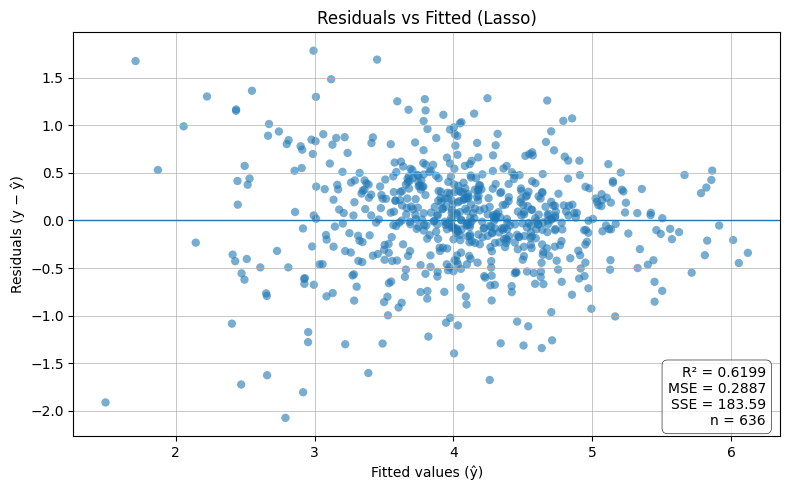

In [ ]:
r2 = r2_score(y_test, y_pred)
resid = y_test - y_pred
sse = float(np.sum(resid**2))
mse = float(sse / len(y_test))

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, resid, alpha=0.6, edgecolor="none")
plt.axhline(0, linewidth=1)
plt.xlabel("Fitted values (ŷ)")
plt.ylabel("Residuals (y − ŷ)")
plt.title("Residuals vs Fitted (Lasso)")
plt.grid(True, linewidth=0.5)

# Stats box
text = f"R² = {r2:.4f}\nMSE = {mse:.4f}\nSSE = {sse:.2f}\nn = {len(y_test)}"
plt.gca().text(
    0.98, 0.02, text,
    transform=plt.gca().transAxes,
    ha="right", va="bottom",
    bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.8, linewidth=0.5)
)

plt.tight_layout()
plt.show()

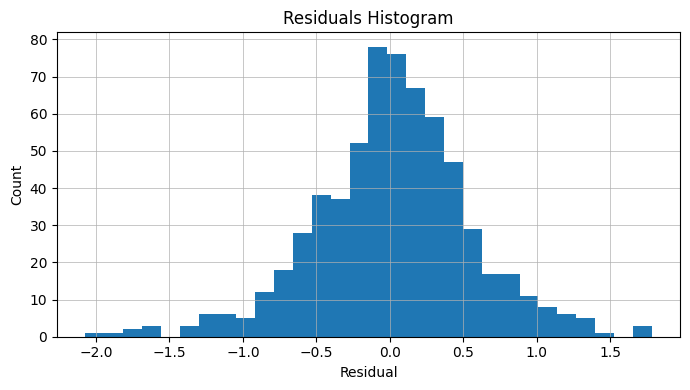

In [ ]:
plt.figure(figsize=(7, 4))
plt.hist(resid, bins=30)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.title("Residuals Histogram")
plt.grid(True, linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# Test values on the validation set.
from __future__ import annotations
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

def evaluate_on_validation(
    X_train, y_train, X_val, y_val, final_lasso, feature="num__SQFT_log1p", decimals=4
):
    # --- helpers ---
    def _col2d(X, feat):
        import pandas as pd, numpy as np
        if isinstance(X, pd.DataFrame):
            if feat not in X.columns:
                raise KeyError(f"Column '{feat}' not found in X.")
            return X[[feat]].to_numpy()
        X = np.asarray(X)
        if isinstance(feat, (int, np.integer)):
            return X[:, [feat]]
        raise TypeError("For ndarray X, 'feature' must be an int index; for DataFrame X, a column name.")

    def _metrics(y_true, y_pred):
        resid = y_true - y_pred
        sse = float(np.sum(resid**2))
        mse = float(sse / len(y_true))
        r2  = float(r2_score(y_true, y_pred))
        return r2, sse, mse

    # --- 1) Baseline mean (fit on train mean, eval on val) ---
    y_train = np.asarray(y_train).ravel()
    y_val   = np.asarray(y_val).ravel()
    mean_val = float(y_train.mean())
    yhat_mean = np.full_like(y_val, fill_value=mean_val, dtype=float)
    r2_mean, sse_mean, mse_mean = _metrics(y_val, yhat_mean)

    # --- 2) One-feature LinearRegression (fit on train, eval on val) ---
    Xtr_col = _col2d(X_train, feature)
    Xva_col = _col2d(X_val, feature)
    lr = LinearRegression().fit(Xtr_col, y_train)
    yhat_lr = lr.predict(Xva_col)
    r2_lr, sse_lr, mse_lr = _metrics(y_val, yhat_lr)

    # --- 3) Final Lasso pipeline (already fit on train), eval on val ---
    yhat_lasso = final_lasso.predict(X_val)
    r2_lasso, sse_lasso, mse_lasso = _metrics(y_val, yhat_lasso)

    # --- pretty print ---
    d = decimals
    print(f"BASELINE mean        : R2={r2_mean:.{d}f}  SSE={sse_mean:.{d}f}  MSE={mse_mean:.{d}f}  n={len(y_val)}")
    print(f"LR[{feature}]        : R2={r2_lr:.{d}f}  SSE={sse_lr:.{d}f}  MSE={mse_lr:.{d}f}  n={len(y_val)}  "
          f"(coef={lr.coef_[0]:.{d}f}, intercept={lr.intercept_:.{d}f})")
    print(f"Lasso (final pipeline): R2={r2_lasso:.{d}f}  SSE={sse_lasso:.{d}f}  MSE={mse_lasso:.{d}f}  n={len(y_val)}")

    # --- return a tidy summary ---
    summary = pd.DataFrame([
        {"model": "baseline_mean", "R2": r2_mean,  "SSE": sse_mean,  "MSE": mse_mean},
        {"model": f"LR[{feature}]", "R2": r2_lr,   "SSE": sse_lr,   "MSE": mse_lr,
         "coef": float(lr.coef_[0]), "intercept": float(lr.intercept_)},
        {"model": "lasso_final",    "R2": r2_lasso,"SSE": sse_lasso,"MSE": mse_lasso},
    ])
    return summary

# ---- Example call ----
summary_val = evaluate_on_validation(X_train, y_train, X_val, y_val, final_lasso, feature="SQFT_log1p")
print(summary_val)


KeyError: "Column 'SQFT_log1p' not found in X."

### Quick thoughts about the above:
When I initially fit an unregularized OLS model, performance collapsed (R² ≈ -8×10²³). This indicates severe multicollinearity in the expanded feature space — a common issue after one-hot encoding. I therefore implemented Ridge and Lasso regularization, which stabilized the solution and improved cross-validated R² to ~0.92. I considered manually examining collinearity of features and pruning appropriately, but, given the width of this dataset, I opted for regularization instead.

Benchmark